In [2]:
import s3fs

import os
import json
import time
import pickle
import requests
import traceback
import time
from datetime import datetime
from sklearn import set_config
import warnings
# Ignore warnings from scikit-learn to make this notebook a bit nicer
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

import pandas as pd
from pandas import DataFrame
from pandas import plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import re
from tqdm.autonotebook import tqdm
tqdm.pandas(desc="progress-bar", leave=False)
import string

import unicodedata  # might need to pip install unicodedate2 on aws sagemaker
import contractions
from contractions import contractions_dict ## pip installed this
from wordcloud import WordCloud, STOPWORDS #pip install
from textblob import TextBlob
!python -m textblob.download_corpora

import nltk
import nltk.corpus 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import word2vec
import multiprocessing as mp

import sklearn
from sklearn.utils import resample # Covert too much Rock! to just enough
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

%matplotlib inline
sns.set(style='darkgrid',palette='Dark2',rc={'figure.figsize':(9,6),'figure.dpi':90})

# Increase screen size.
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline
sns.set(style='darkgrid',palette='Dark2', rc={'figure.figsize':(9,6), 'figure.dpi':100})
# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot
from yellowbrick.target import ClassBalance
from yellowbrick.target import BalancedBinningReference
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.classifier import ConfusionMatrix, ROCAUC, PrecisionRecallCurve, ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.contrib.classifier import DecisionViz
#from mlxtend.plotting import plot_decision_regions

#Pipeline toolset
# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import Normalizer, RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

#Model toolset
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier   
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Evaluation toolset
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score


import pickle
from joblib import dump, load

[nltk_data] Downloading package brown to /Users/Gretzky/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Gretzky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Gretzky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Gretzky/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/Gretzky/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/Gretzky/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [3]:
import io
import boto3

from dotenv import load_dotenv
load_dotenv(verbose=True)

def aws_session(region_name='us-east-1'):
    return boto3.session.Session(aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'), #looks for any .env file
                                aws_secret_access_key=os.getenv('AWS_ACCESS_KEY_SECRET'), #Has to be in same directory
                                region_name=region_name) #from above

def make_bucket(name, acl): 
    session = aws_session()
    s3_resource = session.resource('s3')
    return s3_resource.create_bucket(Bucket=name, ACL=acl)

def upload_file_to_bucket(bucket_name, file_path):
    session = aws_session()
    s3_resource = session.resource('s3')
    file_dir, file_name = os.path.split(file_path)

    bucket = s3_resource.Bucket(bucket_name)
    bucket.upload_file(
      Filename=file_path,
      Key=file_name,
      ExtraArgs={'ACL': 'private'}
    )

    s3_url = f"https://{bucket_name}.s3.amazonaws.com/{file_name}"
    return s3_url

fs = s3fs.S3FileSystem(anon=False,key='###',secret='####')

g_df = pd.read_csv('g2_df') 

In [4]:
g_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [5]:
g_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86290 entries, 0 to 86289
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   genre                   86290 non-null  object 
 1   song_name               86290 non-null  object 
 2   lyrics                  86290 non-null  object 
 3   full_word_count         86290 non-null  int64  
 4   full_character_count    86290 non-null  int64  
 5   full_avg_word_length    86290 non-null  float64
 6   med_lyrics              86290 non-null  object 
 7   med_word_count          86290 non-null  int64  
 8   med_character_count     86290 non-null  int64  
 9   med_avg_word_length     86290 non-null  float64
 10  med_content_affin       86290 non-null  float64
 11  med_sent_label          86290 non-null  object 
 12  med_sent_score          86290 non-null  float64
 13  med_vector              86290 non-null  object 
 14  med_rock_genre_count    86290 non-null

In [6]:
#Decision on what features to include, borne of EDA and visual steering.

df = pd.DataFrame((g_df), columns=['genre','full_word_count','full_character_count','full_avg_word_length',
                                  'med_content_affin','med_sent_score',
                                  'med_rock_genre_count','med_hiphop_genre_count','med_pop_genre_count',
                                   'sml_avg_word_length',
                                  'sml_content_affin','sml_sent_score','sml_vector'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86290 entries, 0 to 86289
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   genre                   86290 non-null  object 
 1   full_word_count         86290 non-null  int64  
 2   full_character_count    86290 non-null  int64  
 3   full_avg_word_length    86290 non-null  float64
 4   med_content_affin       86290 non-null  float64
 5   med_sent_score          86290 non-null  float64
 6   med_rock_genre_count    86290 non-null  float64
 7   med_hiphop_genre_count  86290 non-null  float64
 8   med_pop_genre_count     86290 non-null  float64
 9   sml_avg_word_length     86290 non-null  float64
 10  sml_content_affin       86290 non-null  float64
 11  sml_sent_score          86290 non-null  float64
 12  sml_vector              86290 non-null  object 
dtypes: float64(9), int64(2), object(2)
memory usage: 8.6+ MB


In [8]:
#DOWNSAMPLE

seed = 119

#Separate majority and minority classes, twice.
majority = df[df.genre=='Rock']
minority = df[df.genre=='Hip Hop']

# Downsample majority class
majority_rock_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

seed = 119

#Separate majority and minority classes, again.
majority = df[df.genre=='Pop']
minority = df[df.genre=='Hip Hop']

# Downsample majority class
majority_pop_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

# Combine minority class with downsampled majority class
dfd = pd.concat([majority_rock_downsampled, majority_pop_downsampled, minority])

# Display new class counts
dfd['genre'].value_counts()
# dfd = 'data frame downsampled'

Rock       13560
Pop        13560
Hip Hop    13560
Name: genre, dtype: int64

In [9]:
#Features & Target 

X = dfd.loc[ : , dfd.columns != 'genre']
y = dfd['genre']

In [10]:
#Test & Train Split

from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(32544, 12) (32544,)
(8136, 12) (8136,)


In [11]:
#make label lists for function run below.

cat_labels = list(set(dfd['genre']))
label_lst = list(set(dfd['genre']))

First attempt to create a pipeline.  
While this did give me a first indication of which models would work,it did not include the sml_vector.  It took a couple of attempts to get the TF-IDF to run correctly.

In [12]:
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)


models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]


def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        #('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
        #put it here.....
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted,average='micro')))

Old Code.  Problem with it, the visualize_model and conf_matrix functions were training differently
visualize model is testing on same data it trained on.  Conf_matrix had standard test/train methodology.
You can see the mistake in the bagging classifiers.  Which are over fitting to 1.0 F1 score levels.

In [13]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visualize_model(X, y, estimator,label_lst, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        #('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=label_lst,
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

In [14]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def a_visualize_model(X, y, estimator,label_lst, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        #('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    #Create the train and test data
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

    
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=label_lst,
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

In [15]:
import matplotlib as plt
from yellowbrick.classifier import confusion_matrix

def conf_matrix(X,y,estimator,label_lst):
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        #('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    #Create the train and test data
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

    # Instantiate the visualizer with the classification model
    confusion_matrix(
        model,
        X_train, y_train, X_test, y_test,
        classes=label_lst
    )
    plt.tight_layout()

In [16]:
print("Current Time =", datetime.now())

Current Time = 2021-06-29 12:19:13.630953


F1 SCORE SVC: 0.7195427728613569


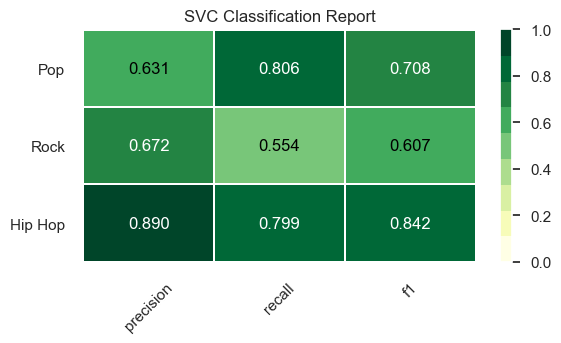

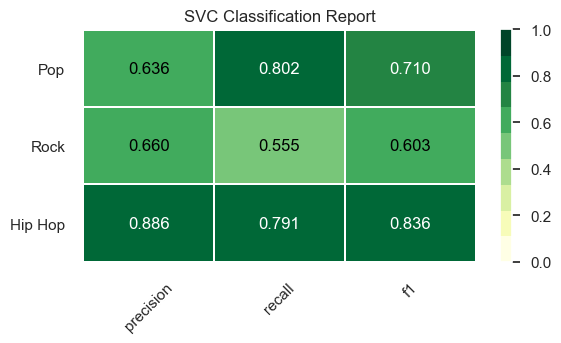

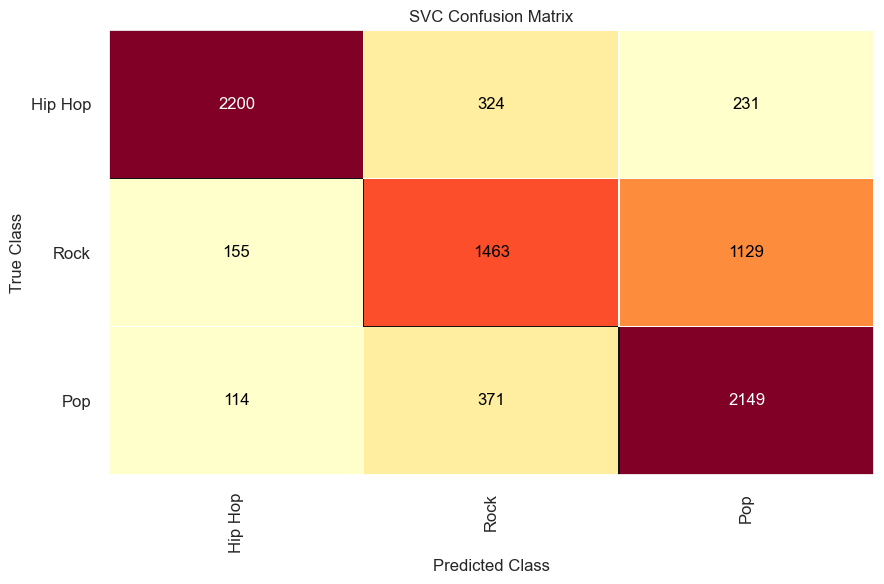

SVC(gamma='auto') Traceback (most recent call last):
  File "<ipython-input-17-b23b109d9fd0>", line 6, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-15-3b8bb45cc005>", line 25, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE NuSVC: 0.7300147492625368


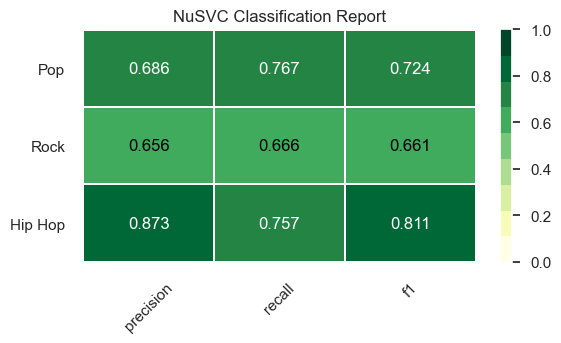

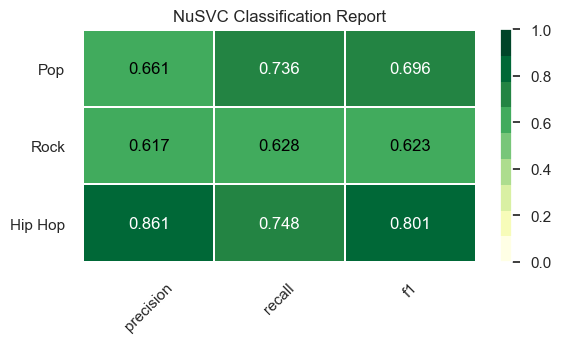

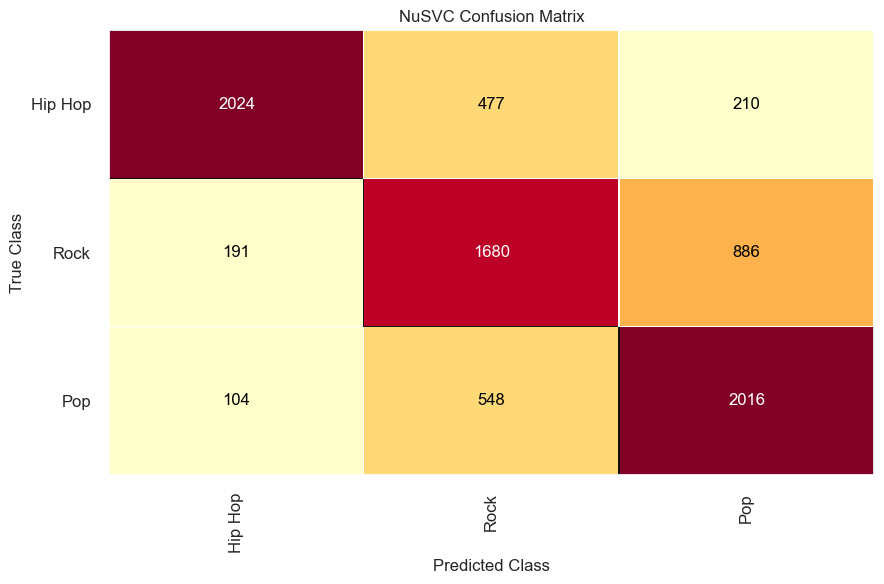

NuSVC(gamma='auto') Traceback (most recent call last):
  File "<ipython-input-17-b23b109d9fd0>", line 6, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-15-3b8bb45cc005>", line 25, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE LinearSVC: 0.7313421828908555


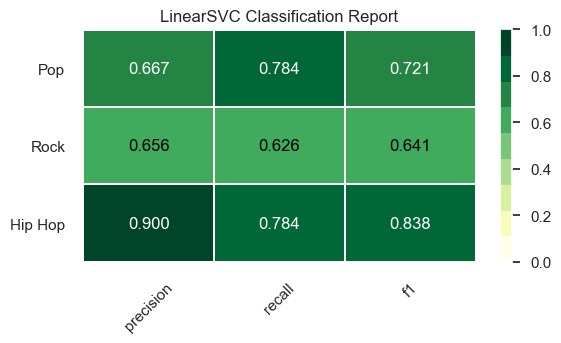

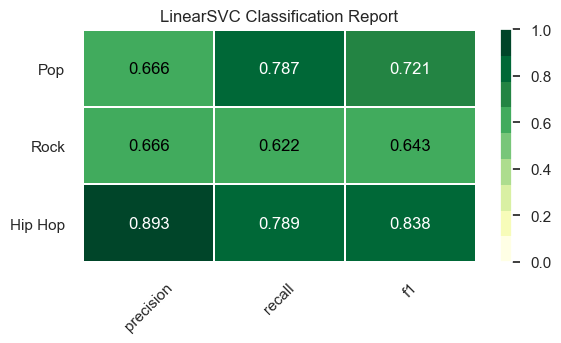

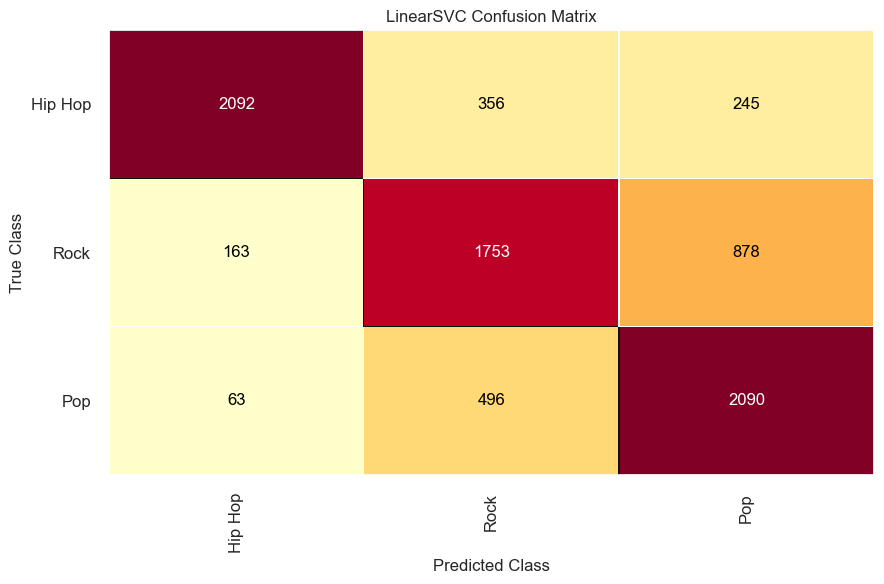

LinearSVC() Traceback (most recent call last):
  File "<ipython-input-17-b23b109d9fd0>", line 6, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-15-3b8bb45cc005>", line 25, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE SGDClassifier: 0.702015732546706


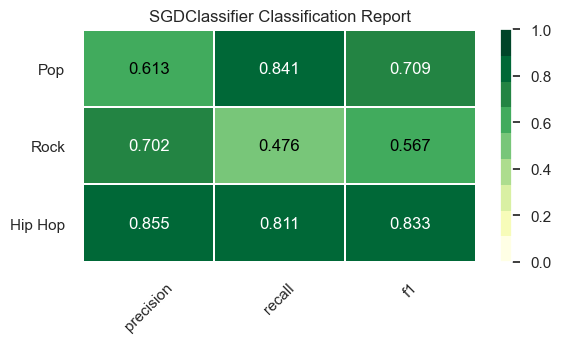

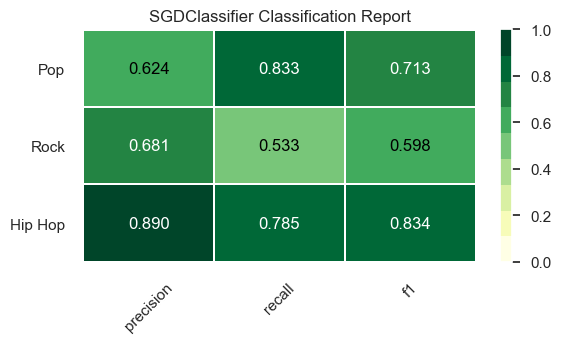

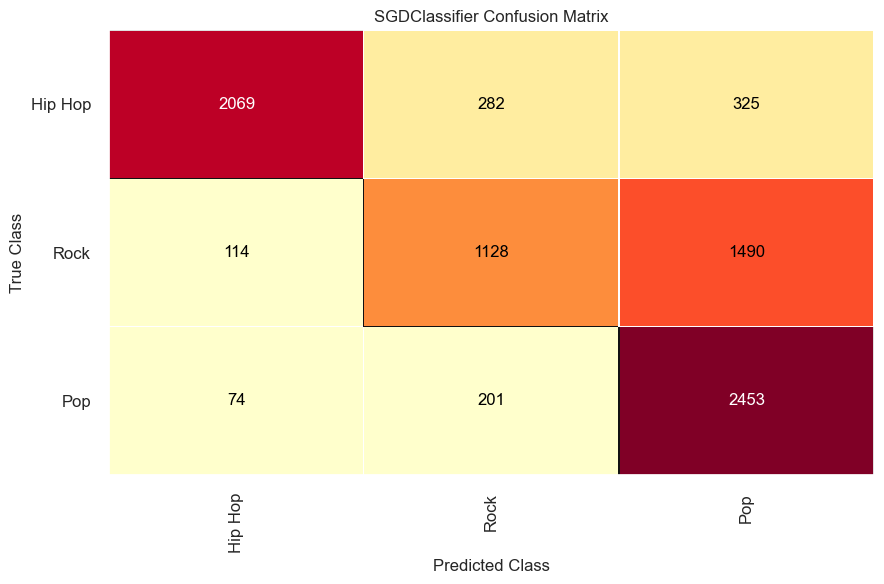

SGDClassifier(max_iter=100) Traceback (most recent call last):
  File "<ipython-input-17-b23b109d9fd0>", line 6, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-15-3b8bb45cc005>", line 25, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE KNeighborsClassifier: 0.7693215339233038


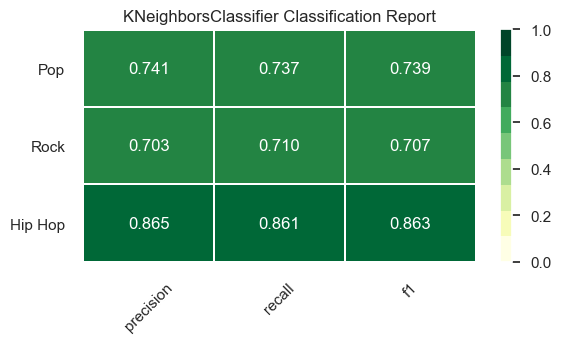

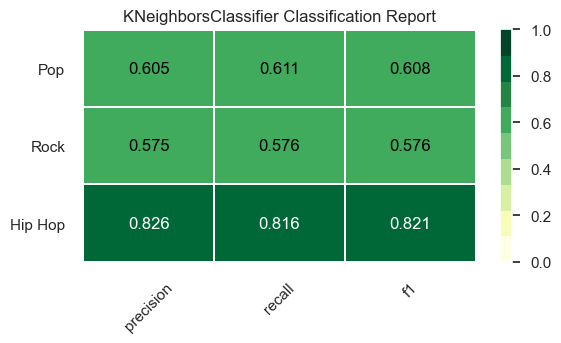

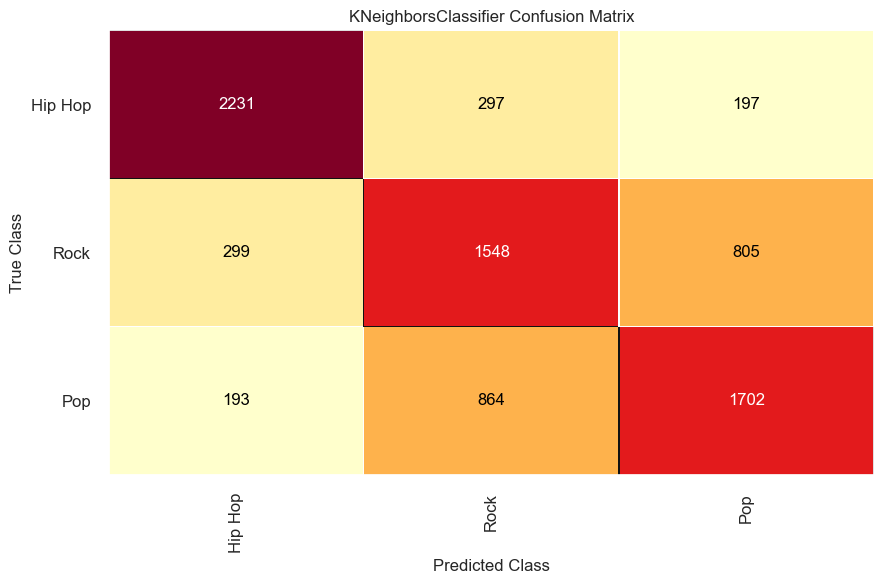

KNeighborsClassifier() Traceback (most recent call last):
  File "<ipython-input-17-b23b109d9fd0>", line 6, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-15-3b8bb45cc005>", line 25, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE LogisticRegression: 0.7275811209439528


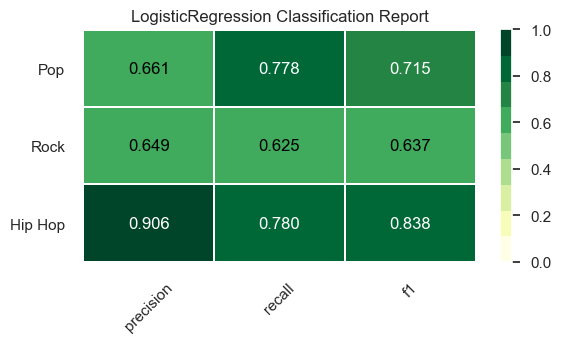

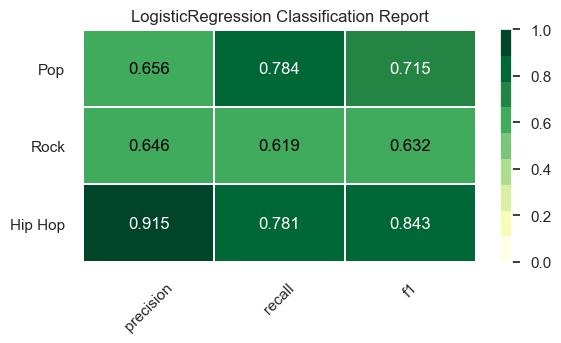

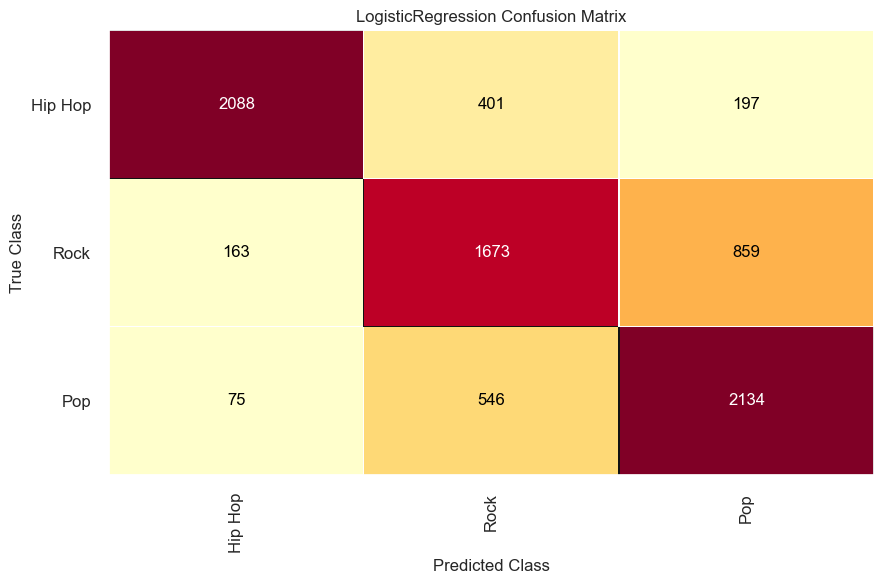

LogisticRegression() Traceback (most recent call last):
  File "<ipython-input-17-b23b109d9fd0>", line 6, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-15-3b8bb45cc005>", line 25, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE LogisticRegressionCV: 0.7375614552605703


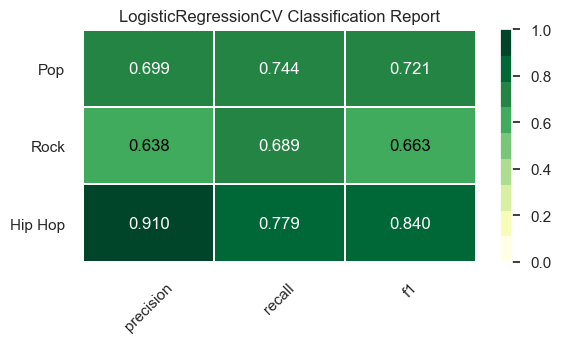

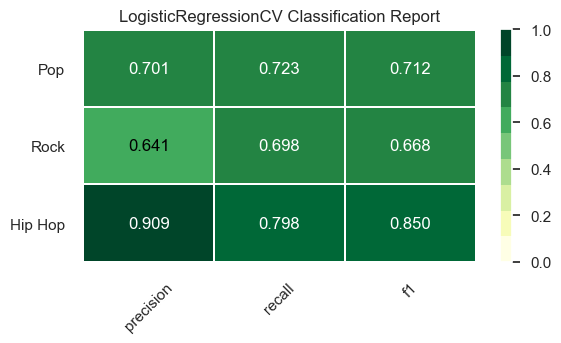

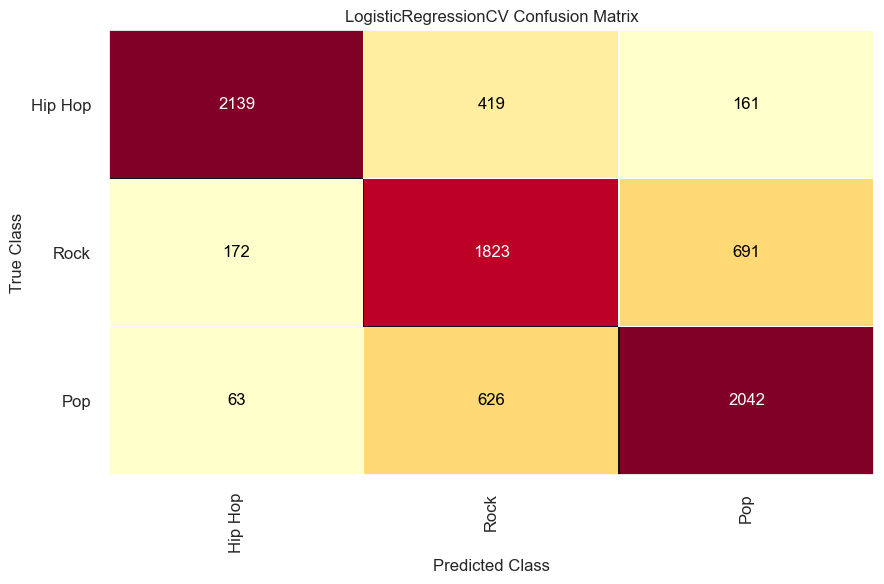

LogisticRegressionCV(cv=3) Traceback (most recent call last):
  File "<ipython-input-17-b23b109d9fd0>", line 6, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-15-3b8bb45cc005>", line 25, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE BaggingClassifier: 0.9860127826941987


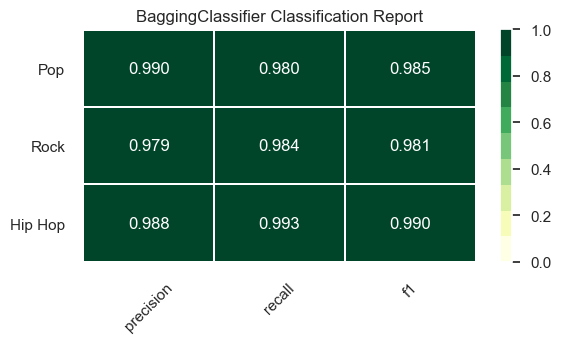

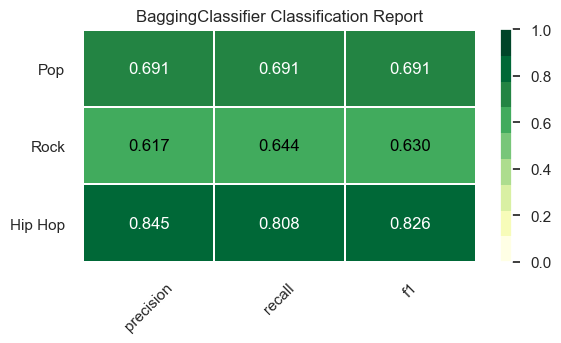

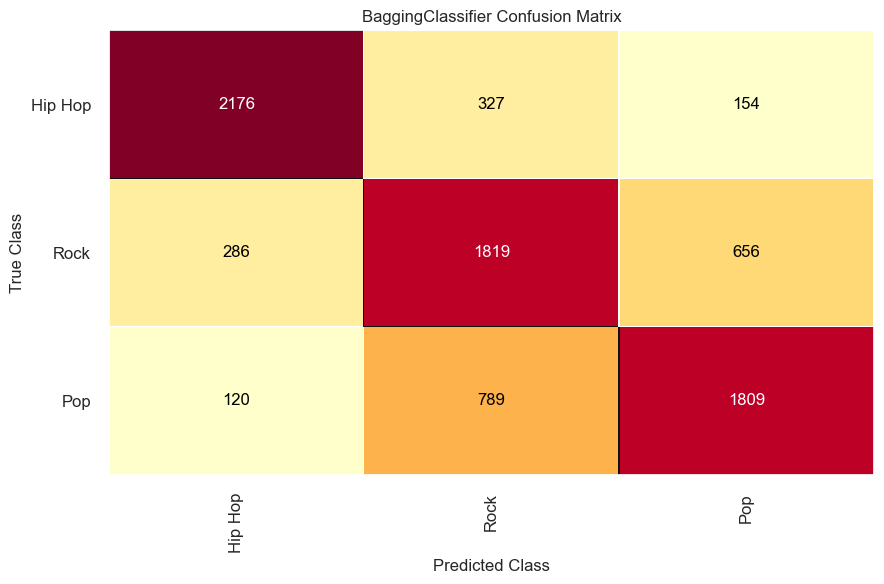

BaggingClassifier() Traceback (most recent call last):
  File "<ipython-input-17-b23b109d9fd0>", line 6, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-15-3b8bb45cc005>", line 25, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE ExtraTreesClassifier: 0.9998770894788593


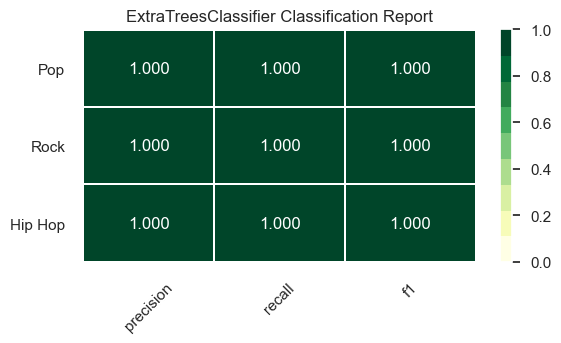

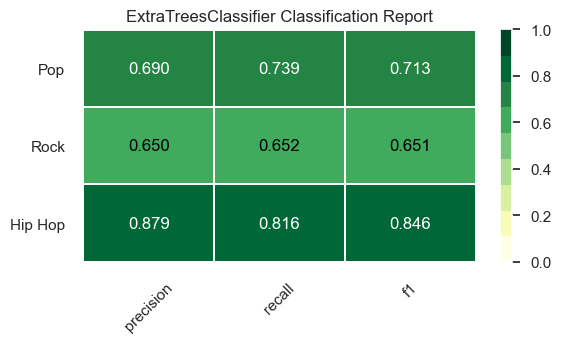

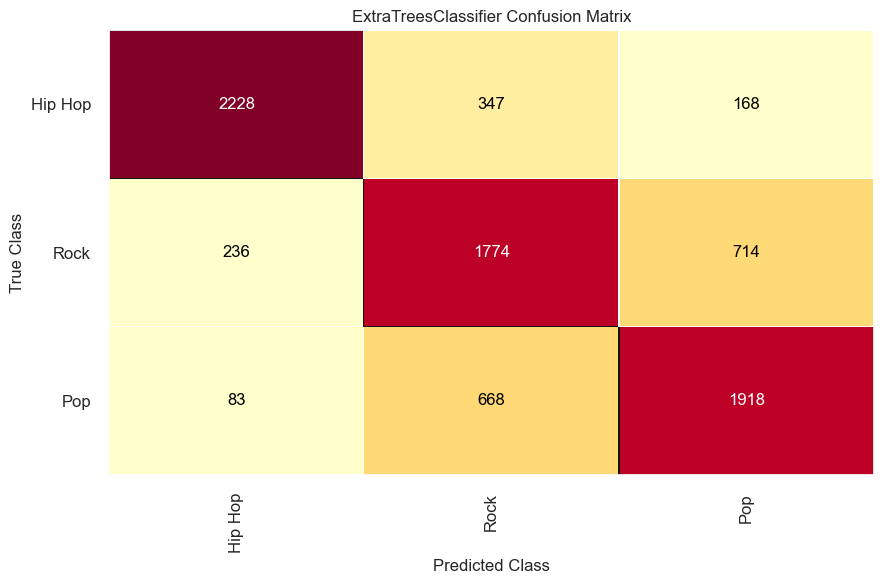

ExtraTreesClassifier(n_estimators=300) Traceback (most recent call last):
  File "<ipython-input-17-b23b109d9fd0>", line 6, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-15-3b8bb45cc005>", line 25, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE RandomForestClassifier: 0.9998770894788593


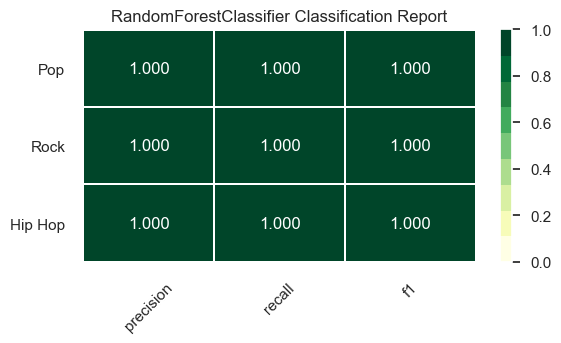

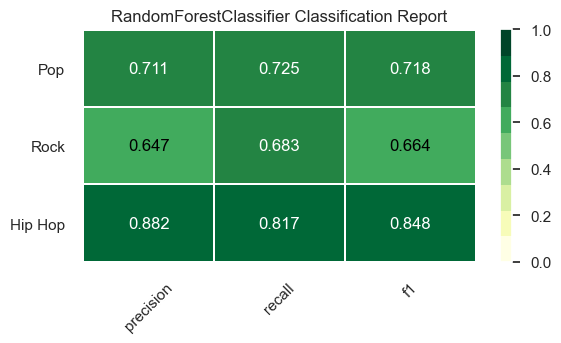

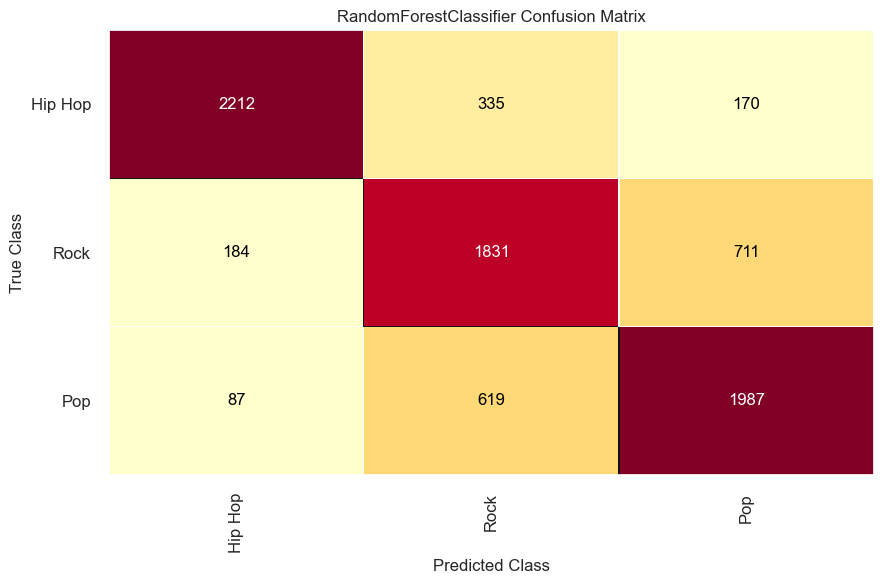

RandomForestClassifier(n_estimators=300) Traceback (most recent call last):
  File "<ipython-input-17-b23b109d9fd0>", line 6, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-15-3b8bb45cc005>", line 25, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable


In [17]:
for model in models:
    try:
        score_model(X, y, model)
        visualize_model(X, y, model,cat_labels)
        a_visualize_model(X, y, model,cat_labels)
        conf_matrix(X, y, model,cat_labels)
    except Exception as exc:
        print(model, 
              traceback.format_exc(), 
              exc)

Attampted to use a Feature Union to join the numerical and the TF-IDF data in the model.  
Could not get it to work in time for the final presentation.

In [18]:
categorical = make_column_selector(pattern='sml_sent_label')
numeric = make_column_selector(dtype_include=np.number)
vector = make_column_selector(pattern='sml_vector')

model = Pipeline([
    ('tfidf', FeatureUnion(
        transformer_list = [
            ('vectorize', Pipeline([
                ('columns_1', ColumnTransformer([
                #('counts', CountVectorizer(), vector),
                ('finally', TfidfVectorizer(),vector),
                ('really', TruncatedSVD(n_components=5, n_iter=7, random_state=42), vector),
            ], remainder='drop')
            )])),
        ('columns_2', ColumnTransformer([
        ('label', OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', 
                                  unknown_value=-1), categorical),
        ('scalar', MinMaxScaler(feature_range=(0,2)), numeric),
        #(Skip_it line from Step_8_DRAFT)
    ], remainder='drop'))
    ],
        transformer_weights= {
            'vectorize': 0.2,
            'columns_2': 0.8,
        }
    )),
    ('clf', LinearSVC())
])

model.fit(X_train, y_train)

viz = ClassificationReport(model, is_fitted = True)
viz.score(X_test, y_test)
viz.show()

ValueError: could not convert string to float: 'seen saturday toxic like girl came eye contact locked phone main chick tell way type cook nigga meal way type pay nigga way twerk like real way hotel star suite sun go watch turn freak bad bitch breaking rule cuz yeah know nigga help understand tempted looking looking freak yeah daily yeah know talking seven day week yeah hurt tell knew yeah started think talking talking talking talking talking talk talk talkin bout talk talkin bout talkin bout talkin bout hotel star suite sun go watch turn freak bad bitch got instagram like know bitch know got man yeah met bitch want french kiss flew yeah tellin got devil dress best hell know know hotel star suite sun go watch turn freak bad bitch rule tell talking talking talking talking talking talk talk talkin bout talk talkin bout talkin bout talkin bout'

Went back to basics and built a coulmn transformer from the ground up.  This ran and enabled me to experiment with the various Scalers.  But it was not as smooth as it would have been with a better FeatureUnion coded up.  Also, lost the ability to decide which estimators to weigh by how much in the final model.

In [19]:
#Start over, clean.

g_df = pd.read_csv('g2_df')
#Drop first, useless column.
g_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

#Feature Selection

df = pd.DataFrame((g_df), columns=['genre','full_word_count','full_character_count',
                                  'med_rock_bool','med_hiphop_bool','med_pop_bool',
                                   'sml_word_count','sml_character_count',
                                   'sml_content_affin','sml_sent_label','sml_vector'])

#DOWNSAMPLE

seed = 99

#Separate majority and minority classes, twice.
majority = df[df.genre=='Rock']
minority = df[df.genre=='Hip Hop']

# Downsample majority class
majority_rock_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

seed = 99

#Separate majority and minority classes, again.
majority = df[df.genre=='Pop']
minority = df[df.genre=='Hip Hop']

# Downsample majority class
majority_pop_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

# Combine minority class with downsampled majority class
dfd = pd.concat([majority_rock_downsampled, majority_pop_downsampled, minority])

# Display new class counts
dfd['genre'].value_counts()
# dfd = 'data frame downsampled'


# Declare Target and Features
target = dfd.genre
features = dfd[['full_word_count','full_character_count',
                                  'med_rock_bool','med_hiphop_bool','med_pop_bool',
                                    'sml_word_count','sml_character_count',
                                   'sml_content_affin','sml_sent_label','sml_vector']].copy()

#Test Train Split

X_train, X_test, y_train, y_test = tts(features, target, test_size = 0.2, random_state=123)
print(df.shape); print(X_train.shape); print(X_test.shape)

(86290, 11)
(32544, 10)
(8136, 10)


In [20]:
# defining the numerical, categorical and textual features
numerical = ['full_word_count','full_character_count','sml_word_count','sml_character_count']
negative_values = ['sml_content_affin','med_rock_bool','med_hiphop_bool','med_pop_bool']
categorical = ['sml_sent_label']
textual = ['sml_vector']

In [21]:
#This version of the modeling divides the scaling/configuring the data from the fit.transform 
#of the model.  It works in a controlled fashion, but changing a model or a scaler requires re-running
#many blocks of code.

ct = ColumnTransformer(
    [('num', RobustScaler(), numerical),
     ('neg_values', MinMaxScaler(feature_range=(0,2)), negative_values),
     ('cat', OneHotEncoder(),categorical),
     ('tfidf', TfidfVectorizer(max_features = 6000, stop_words = 'english', ngram_range=(1,1)), 'sml_vector')
    ], n_jobs=3, verbose=True)

In [22]:
set_config(display='diagram')
ct

ColumnTransformer(n_jobs=3,
                  transformers=[('num', RobustScaler(),
                                 ['full_word_count', 'full_character_count',
                                  'sml_word_count', 'sml_character_count']),
                                ('neg_values',
                                 MinMaxScaler(feature_range=(0, 2)),
                                 ['sml_content_affin', 'med_rock_bool',
                                  'med_hiphop_bool', 'med_pop_bool']),
                                ('tfidf',
                                 TfidfVectorizer(max_features=6000,
                                                 stop_words='english'),
                                 'sml_vector')],
                  verbose=True)

In [23]:
%%time
# Creating the feature matrix
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)
print(f'Shape of Term Frequency Matrix of train: {X_train.shape}')
print(f'Shape of Term Frequency Matrix of test: {X_test.shape}')

Shape of Term Frequency Matrix of train: (32544, 6008)
Shape of Term Frequency Matrix of test: (8136, 6008)
CPU times: user 217 ms, sys: 230 ms, total: 447 ms
Wall time: 4.01 s


In [24]:
%%time

Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)
print(y_train.shape); print(y_test.shape)

(32544,)
(8136,)
CPU times: user 20.2 ms, sys: 1.83 ms, total: 22.1 ms
Wall time: 21 ms


In [25]:
#Confirming the target classes. 
classes = Encoder.classes_
classes

array(['Hip Hop', 'Pop', 'Rock'], dtype=object)

In [26]:
%%time
# Decision tree classifier
dtc = DecisionTreeClassifier(criterion = 'gini', splitter='best', random_state=seed)
# Training the model 
dtc.fit(X_train, y_train)

#Predict the Test using decision tree 
y_pred_dtc = dtc.predict(X_test)

print('Accuracy on x_train is',dtc.score(X_train, y_train))
print('Accuracy on x_test is',dtc.score(X_test, y_test))

Accuracy on x_train is 0.9999078171091446
Accuracy on x_test is 0.6991150442477876
CPU times: user 17.6 s, sys: 32.6 ms, total: 17.7 s
Wall time: 17.7 s


In [27]:
#save model for future use, comes in handy if a need to re-run code blocks.  Avoids re-running the model.

#save
dump(dtc, 'dtc.joblib')
#load
#dtc = load('dtc.joblib') 

['dtc.joblib']

Used the three visualizations below to look at the various models.  Went through all of the models, picked four and then moved on to hyperparameter tuning.

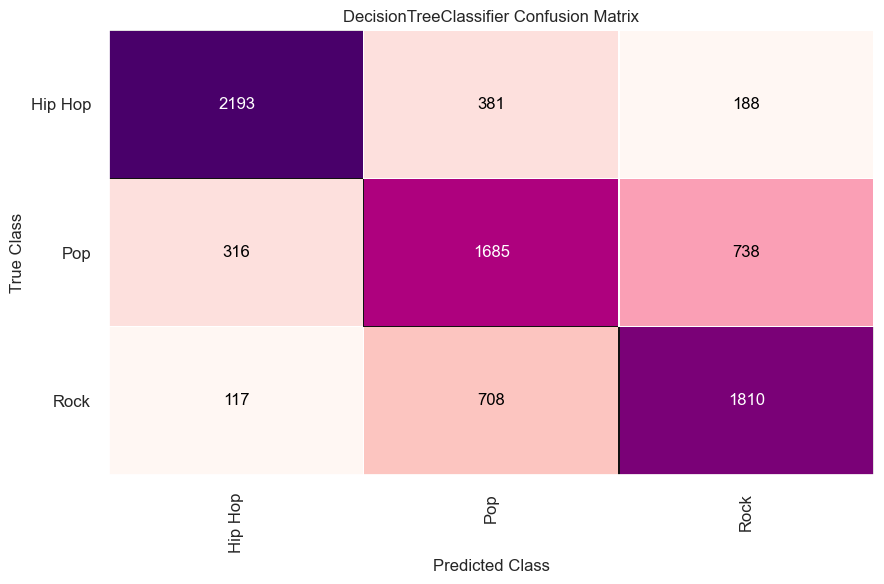

CPU times: user 149 ms, sys: 206 ms, total: 355 ms
Wall time: 128 ms


<AxesSubplot:title={'center':'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [29]:
%%time

cm_dtc = ConfusionMatrix(dtc, classes=classes, cmap='RdPu')
cm_dtc.fit(X_train, y_train)
cm_dtc.score(X_test, y_test)
cm_dtc.show()

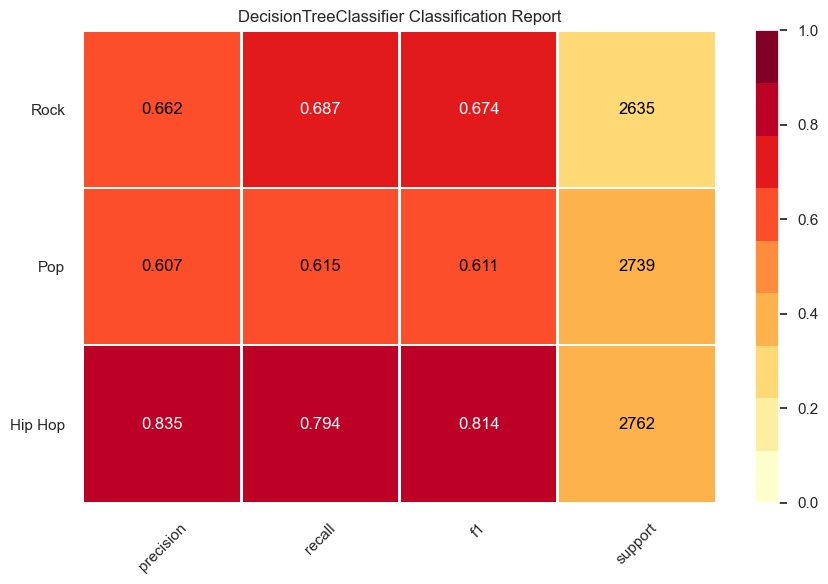

<AxesSubplot:title={'center':'DecisionTreeClassifier Classification Report'}>

In [30]:
cr_dtc = ClassificationReport(dtc, classes=classes, support=True)
cr_dtc.fit(X_train, y_train)
cr_dtc.score(X_test, y_test)
cr_dtc.show()

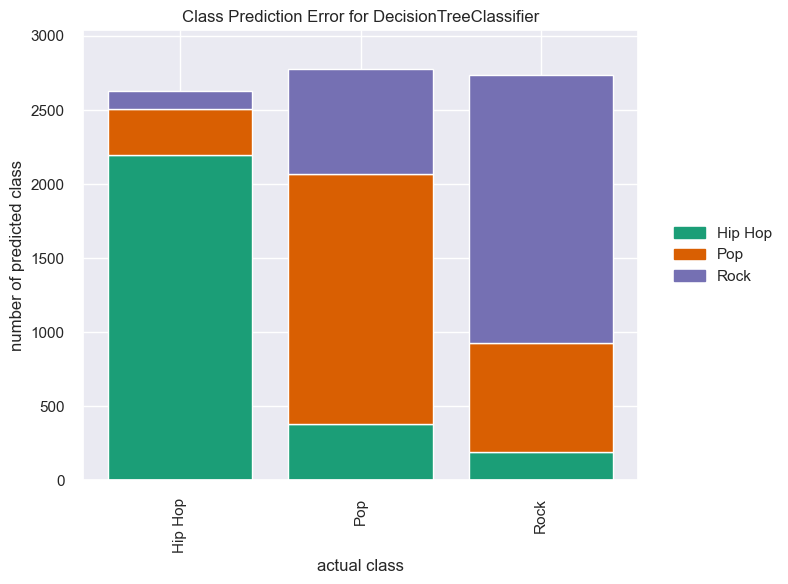

<AxesSubplot:title={'center':'Class Prediction Error for DecisionTreeClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [31]:
cpe_dtc = ClassPredictionError(dtc, classes=classes)
cpe_dtc.fit(X_train, y_train)
cpe_dtc.score(X_test, y_test)
cpe_dtc.show()